# Analyzing Passive Acoustic Data with MHKiT

The following example illustrates how to read and analyze passive acoustics data collected by a hydrophone. This functionality to has been primarily integrated into MHKiT to support analysis based on the IEC-TS 62600-40 technical standard for marine energy devices.

The standard workflow for passive acoustics analysis is as follows:

1. Import a .wav file
2. Calibrate pressure sensitivity
3. Calculate spectral density
4. Calculate other parameters
5. Create plots

We'll import a couple plotting tools and the acoustics module:

In [1]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from mhkit import acoustics

### Read Hydrophone Data

Hydrophones typically output a .wav file, which can be read in MHKiT using a base function called `read_hydrophone` from the acoustics.io submodule. Because a hydrophone's sampling frequency is so fast, measurements are stored in the lowest memory format possible and need to be scaled and transformed to return the measurements in physical units of voltage or pressure.

The `read_hydrophone` function scales and transforms raw measurements given a few input parameters. Most parameters needed to convert the raw data are stored in the native .wav format header blocks, but two, the peak voltage ("peak_voltage") of the sensor's analog-to-digital converter (ADC) and file "start_time" (usually stored in the filename) are required. 

Two other inputs, the hydrophone sensitivity ("sensitivity") and an amplifier gain ("gain") can also be input. If a sensitivity value is provided, the function will convert voltage to pressure; otherwise the sensitivity(ies) can be provided later using a calibration curve. Gain should be provided if the instrument utilizes an amplifier gain (typically for custom hydrophone builds), which is then added to the sensitivity.

In [2]:
P = acoustics.io.read_hydrophone(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    peak_voltage=3, 
    sensitivity=-177, 
    gain=0, 
    start_time="2024-06-01T05:31:14"
)
# `P` is returned as an xarray DataArray, which allows easy handling of labeled multi-dimensional arrays. 
# In this case, the array represents sound pressure in Pascals (Pa) over time because the calibrated sensitivity was passed.
print(P)

<xarray.DataArray (time: 30720000)> Size: 246MB
array([0.31546374, 0.30229832, 0.32229963, ..., 0.08506887, 0.07291618,
       0.06278893])
Coordinates:
  * time     (time) datetime64[ns] 246MB 2024-06-01T05:31:14 ... 2024-06-01T0...
Attributes:
    units:        Pa
    sensitivity:  1.413e-09
    resolution:   9.89e-07
    valid_min:    -2123.837353
    valid_max:    2123.837353
    fs:           512000
    filename:     RBW_6661_20240601_053114


"Smart" hydrophones are those where the hydrophone element, pre-amplifier board, analog-to-digital converter (ADC), motherboard and memory card are sold in a single package. Companies that sell these often store metadata in the .wav file header.

MHKiT has wrapper functions for OceanSonics icListen and OceanInstruments Soundtrap hydrophones, with examples as follows.

For icListen datafiles, only the filename is necessary to provide to return file contents in units of pressure. The stored sensitivity calibration value can be overridden by setting the "sensitivity" input to a predetermined value. If sensitivity calibration data is on hand, return measurements in units of voltage by setting `sensitivity` to None and `use_metadata` to False.

In [3]:
# Pressure output
P = acoustics.io.read_iclisten("data/acoustics/RBW_6661_20240601_053114.wav")
# Voltage output
V = acoustics.io.read_iclisten(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    sensitivity=None, 
    use_metadata=False
)

For Ocean Instruments Soundtrap datafiles, the filename and sensitivity should be provided to return the measurements in units of pressure. Again, if the hydrophone has been calibrated, set the sensitivity to None to return the measurements in units of voltage.

In [4]:
P = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=-177)
V = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=None)

### Mean Square Sound Pressure Spectral Density

After the .wav file is read, either in units of pressure or voltage, we calculate the mean square sound pressure spectral density (SPSD) of the time-series using `sound_pressure_spectral_density`. This splits the timeseries into windows and uses fast Fourier transforms to convert the raw measurements into the frequency domain, with units of $Pa^2/Hz$ or $V^2/Hz$, depending on the input. The function takes the original datafile, the hydrophone's sampling rate ("fs"), which is stored as an attribute of the measurement timeseries, and a window size ("bin_length") in seconds as input.

The IEC-40 considers an acoustic sample to have a length of 1 second, so we'll set the bin length as such here.

In [5]:
# Create mean square spectral densities using 1 s bins.
spsd = acoustics.sound_pressure_spectral_density(V, fs=V.fs, bin_length=1)

### Applying Calibration Curves

For conducting scientific-grade analysis, it is critical to use calibration curves to correct the SPSD calculations. Hydrophones should be calibrated (i.e., a sensitivity calibration curve should be generated for a hydrophone) every few years. The IEC-40 asks that a hydrophone be calibrated both before and after the test deployment.

A calibration curve consists of the hydrophone's sensitivity (in units of $dB$ $rel$ $1$ $V^2/uPa^2$) vs frequency and should be applied to the spectral density we just calculated.

The easiest way to apply a sensitivity calibration curve in MHKiT is to first copy the calibration data into a CSV file, where the left column contains the calibrated frequencies and the right column contains the sensitivity values. Here we use the function in the following codeblock to read in a CSV file created with the column headers "Frequency" and "Analog Sensitivity".

In [6]:
import pandas as pd

def read_calibration_file(filename):
    calibration = pd.read_csv(filename, sep=",")
    calibration.index = calibration["Frequency"]
    calibration = calibration.to_xarray()
    return calibration["Analog Sensitivity"]

sensitivity_curve = read_calibration_file("data/acoustics/6247_calibration.csv")
print(sensitivity_curve)

<xarray.DataArray 'Analog Sensitivity' (Frequency: 40)> Size: 320B
array([-223.49, -220.8 , -218.13, -215.41, -212.68, -209.91, -207.12,
       -204.29, -201.45, -198.58, -195.69, -192.79, -189.85, -186.9 ,
       -183.93, -180.93, -177.92, -174.97, -172.16, -169.61, -167.69,
       -166.52, -165.96, -165.81, -165.85, -165.95, -166.05, -166.13,
       -166.2 , -166.25, -166.28, -166.29, -166.29, -166.27, -166.24,
       -166.17, -166.03, -165.79, -165.47, -164.87])
Coordinates:
  * Frequency  (Frequency) float64 320B 1.0 1.183 1.399 ... 500.3 591.8 700.0


Once we have the calibration data in an xarray DataArray, we can apply that to the SPSD using the `apply_calibration` function. Calibration curves typically do not cover the entire range of the hydrophone, so this function will linearly interpolate the missing values. A fill_value can be provided to extrapolate outside of the calibrated frequencies.

In [7]:
# Use last value in calibration curve for higher frequencies
fill_Sf = sensitivity_curve[-1].values
spsd = acoustics.apply_calibration(spsd, sensitivity_curve, fill_value=fill_Sf)

### Mean Square Sound Pressure Spectral Density Level

We can use the function `sound_pressure_spectral_density_level` to calculate the mean square sound pressure spectral density levels (SPSDLs) from the calibrated SPSD. This function converts absolute pressure into relative pressure in log-space, the traditional means with which we measure sound, in units of decibels relative to 1 uPa [dB rel 1 uPa], the standard for underwater sound. 
    
Sidenote: Sound in air is measured in decibels relative to 20 uPa, the minimum sound pressure humans can hear. To convert between [dB rel 1 uPa] and [dB rel 20 uPa], one simply needs to subtract 26 dB from the [dB rel 1 uPa] value.

In [8]:
spsdl = acoustics.sound_pressure_spectral_density_level(spsd)

Now that the SPSDL is calculated, we can create spectrograms, or waterfall plots, using the `plot_spectrogram` function in the graphics submodule. While spectrograms aren't required by the IEC-40, they are useful to do quality control so we can avoid using contaminated soundbytes in further analysis (i.e., we'd remove the boat noise shown here from further analysis of a marine energy device).

To do this, we'll give the function the minimum and maximum frequencies to plot, as well as keyword arguments supplied to the matplotlib `pcolormesh` function. For these measurements, we're setting fmin = 10 Hz, the minimum specified by the IEC-40, and fmax = 48,000 Hz, the Nyquist frequency for these data. 

Note, the IEC-40 requires a maximum frequency of 100,000 Hz, so a hydrophone capable of sampling faster than 200,000 Hz should be used for IEC testing.

In [9]:
# Show Nyquist frequency (maximum in frequency vector)
print(spsdl["freq"].max())

<xarray.DataArray 'freq' ()> Size: 8B
array(48000.)


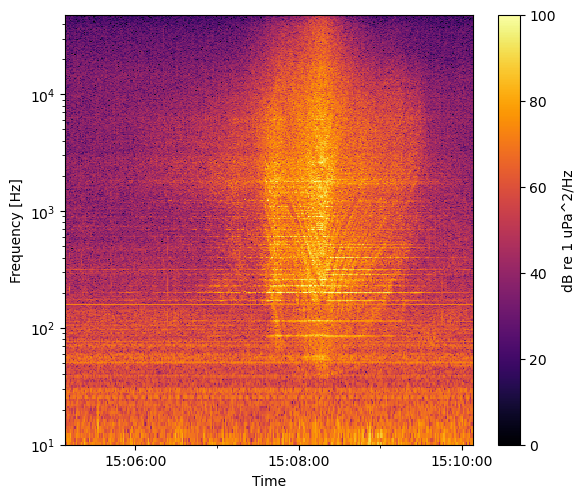

In [10]:
fmin = 10
fmax = 48000

# Create high resolution spectrogram
kwargs={"cmap": "inferno", "vmin": 0, "vmax": 100}
fig, ax = acoustics.graphics.plot_spectrogram(
    spsdl, fmin, fmax, **kwargs
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())


If you see something interesting in the spectrogram, the next step you should do is listen to the .wav file. This can tell you a lot about what you're looking at. If you listen to this file, you'll hear the boat cruising by around 3 minutes in.

Some audio players aren't able to play some hydrophone recodings (i.e., icListens), so be sure to try different players if you can't hear anything in one particular player. Higher-end hydrophones tend to user higher ADC peak voltages, which will translate to quieter audio tracks. You can use the `export_audio` file in the io submodule to rescale these audio tracks and increase the gain if need be.

In [11]:
# Uncomment to save new file
filename = "sound1.wav"
#acoustics.io.export_audio(filename, P, gain=1)

### IEC-40 Stats

The IEC-40 requires a few aggregate statistics for characterizing the sound of marine energy devices. For the first, the IEC-40 asks for plots showing the 25%, 50%, and 75% quantiles of the SPSDL during specific marine energy device states. For current energy devices, the IEC-40 requires 10 SPSDL samples at a series of turbine states (braked, freewheel, 25% power, 50% power, 75% power, 100% power). For wave energy devices, the spec requires 30 SPSDL samples in each wave height and period bin observed.

For this example notebook we'll keep it simple and use a random set of 30 samples and collate them together. Typically, one will pick and choose which 1 second samples to collate together and analyze. Then we can find the median and quantiles of those 30 samples.

[(20.0, 80.0),
 Text(0, 0.5, 'Sound Pressure Spectral Density Level\n[dB rel 1 uPa^2/Hz]')]

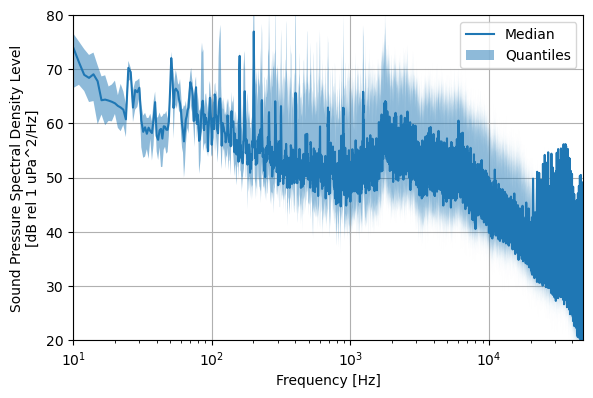

In [12]:
import random
samples = random.sample(range(spsdl["time"].size), 30)
spsdl_clip = spsdl.isel(time=samples)

spsdl_median = spsdl_clip.median("time")
spsdl_q25 = spsdl_clip.quantile(0.25, "time")
spsdl_q75 = spsdl_clip.quantile(0.75, "time")

# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_median, fmin, fmax, label="Median")
ax.fill_between(
    spsdl_clip["freq"],
    spsdl_q25,
    spsdl_q75,
    alpha=0.5,
    facecolor="C0",
    edgecolor=None,
    label="Quantiles"
)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.grid()
ax.set(ylim=(20, 80), ylabel="Sound Pressure Spectral Density Level\n[dB rel 1 uPa^2/Hz]")

### Window Aggregating

If desired, one can group a series of measurements into blocks of time, though this isn't required by the IEC-40. In the following block, we'll take our 5 minutes of measurements, `time_aggregate` them into 30 second intervals, and find the median, 25% and 75% quantiles of each interval. We then plot the stats of the median parameters.

In [13]:
# Time average into 30 s windows and take the median parameter value
window = 30
spsdl_time = acoustics.time_aggregate(spsdl, window, method="median")

We can then using the `plot_spectra` function in the graphics submodule to plot the median and quantiles of the first 30 s window.

[(20.0, 80.0),
 Text(0, 0.5, 'Sound Pressure Spectral Density Level\n[dB rel 1 uPa^2/Hz]')]

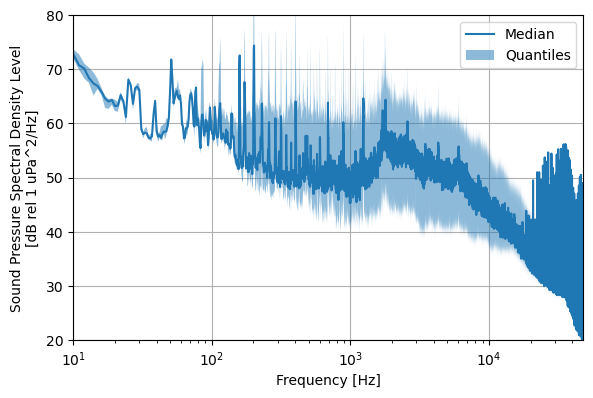

In [14]:
# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_time.median("time_bins"), fmin, fmax, label="Median")
ax.fill_between(
    spsdl_time["freq"],
    spsdl_time.quantile(0.25, "time_bins"),
    spsdl_time.quantile(0.75, "time_bins"),
    alpha=0.5,
    facecolor="C0",
    edgecolor=None,
    label="Quantiles"
)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.grid()
ax.set(ylim=(20, 80), ylabel="Sound Pressure Spectral Density Level\n[dB rel 1 uPa^2/Hz]")

### Frequency Band Analysis

Frequency band analysis can be completed by grouping the data into specific frequency bands, called "band aggregating" here. In other words, instead of aggregating by the time dimension, we aggregate by the frequency dimension. The `band_aggregate` function operates by taking the SPSDL and grouping it based on a specified octave and octave base.

In the following codeblock, we use the same plotting function as above, but do so by creating the decidecade frequency bands (10th octave, octave base 10 => $10^{1/10}$). We'll calculate the median and quantiles of each sample, then take the median of each of those parameters. For the IEC-40, one will calculate these parameters for each device operating state (current energy converters) or wave state matrix (wave energy converters).

[(20.0, 80.0), Text(0, 0.5, 'Decidecade SPSDL [dB rel 1 uPa^2/Hz]')]

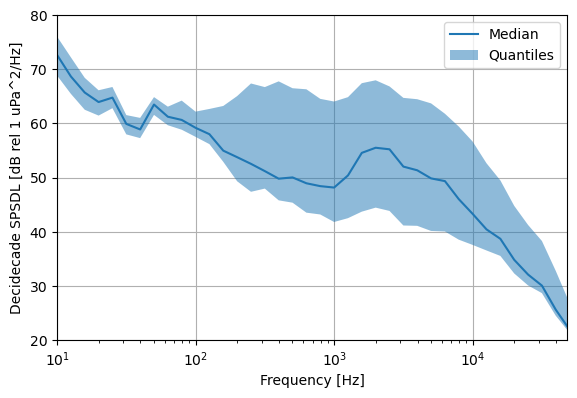

In [15]:
octave = [10, 10]  # [octave, octave base]
spsdl10 = acoustics.band_aggregate(spsdl, octave, fmin, fmax, method="median")

# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl10.median("time"), fmin, fmax, label="Median")
ax.fill_between(
    spsdl10["freq_bins"],
    spsdl10.quantile(0.25, "time"),
    spsdl10.quantile(0.75, "time"),
    alpha=0.5,
    facecolor="C0",
    edgecolor=None,
    label="Quantiles"
)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.grid()
ax.set(ylim=(20, 80), ylabel="Decidecade SPSDL [dB rel 1 uPa^2/Hz]")

The plot above shows significant spread in sound measurements at higher frequency due to the vessel noise, but less so at lower frequency. This mirrors what we can see in the sound pressure density level figure we first plotted.

Boxplots for each frequency band can also be created instead of simple line plots. We can use the aggregate methods to apply plotting functions, like matplotlib's native boxplot. In this case, we'll supply the "map" function and an iterable of the custom function inputs (the figure axes we want to use to plot).

[[<matplotlib.axis.XTick at 0x1df861ae5d0>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5')],
 (1.0, 4.8),
 (20.0, 100.0),
 Text(0.5, 0, 'log(Frequency) [Hz]'),
 Text(0, 0.5, 'Decidecade SPSDL [dB re 1 uPa^2/Hz]')]

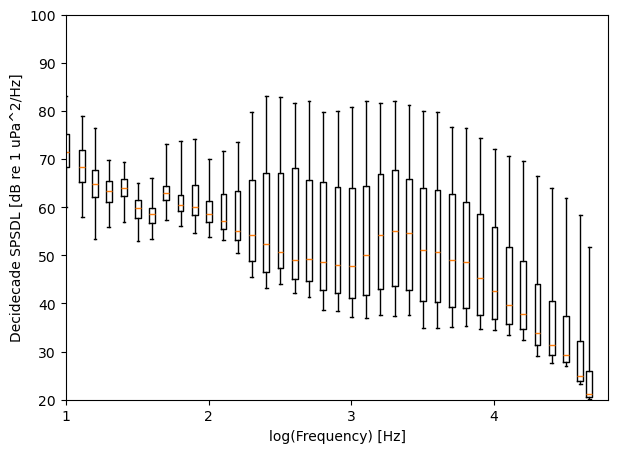

In [16]:
def boxplot(x, ax):
    # Use the median of the coordinate we're grouped in
    freq = x["freq"].median()
    x = x.mean("freq")
    # Create boxplots
    ax.boxplot(
        x.values,
        whis=(1, 99),
        showfliers=False,
        positions=[np.log10(freq.values)],
        widths=0.04,
        flierprops={"marker": ".", "markersize": 2},
    )
    return x

fig, ax = plt.subplots(figsize=(7, 5))
acoustics.band_aggregate(
    spsdl, octave, fmin, fmax, method={"map": (boxplot, [ax])}
)
xticks = np.linspace(0, 5, 6)
ax.set(
    xticks=xticks,
    xticklabels=xticks.astype(int),
    xlim=(1, 4.8),
    ylim=(20, 100),
    xlabel="log(Frequency) [Hz]",
    ylabel="Decidecade SPSDL [dB re 1 uPa^2/Hz]",
)

The "map" function will also allow one to conduct further frequency band analysis than the simple statistical methods that xarray offers. In the following block of code, we find the empirical quantile function (the empirical version of the cumulative distribution function, CDF) of each decidecade frequency band and plot the decidecade band centered at 158 Hz. 

[Text(0.5, 1.0, '158.49 Hz'),
 Text(0, 0.5, 'Exceedance Probability'),
 Text(0.5, 0, 'SPSDL [dB re 1 uPa^2/Hz]')]

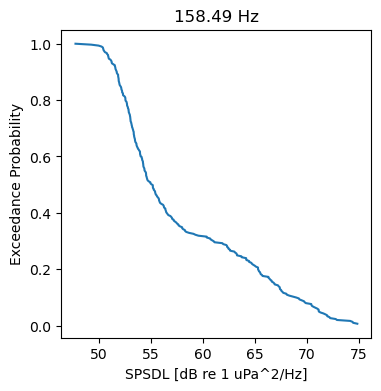

In [17]:
def quantile_function(x):
    # Empirical CDF/Quantile Function/Exceedance Probability
    # Use the median of the coordinate we're grouped in
    x = x.median("freq")
    # Squeeze to remove frequency dimension
    shape = np.shape(x)
    x_sorted = np.sort(np.squeeze(x))
    # calculate the proportional values of samples
    p = 1.0 - np.arange(len(x)) / (len(x) + 1)
    # recreate dataarray
    x = x.assign_coords({"time": p}).rename({"time": "probability"})
    x.values = np.reshape(x_sorted, shape)
    return x


octave = [10, 10]  # 1/10th octave at base 10
cdfs = acoustics.band_aggregate(spsdl, octave, fmin, fmax, method={"map": quantile_function})
# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(cdfs.sel(freq_bins=160, method="nearest").values, cdfs["probability"].values)
ax.set(
    title=f"{np.round(cdfs['freq_bins'].sel(freq_bins=160, method='nearest').values, 2)} Hz",
    ylabel="Exceedance Probability",
    xlabel="SPSDL [dB re 1 uPa^2/Hz]",
)

### Sound Pressure Level

The IEC-40 has two requirements considering calculations of sound pressure level (SPL). We'll first calculate the SPL over the full frequency range of the turbine and/or hydrophone using the function `sound_pressure_level`. First, however, note that the IEC-40 asks that the range be set from 10 to 100,000 Hz. The lower limit can be increased due to flow noise or low frequency signal loss due to shallow water. 

#### Shallow water cutoff frequency
Low frequency sound is absorbed into the seabed in shallow water depths. We can use the function `minimum_frequency` to get an approximation of what our minimum frequency should be. This approximation uses the water depth, estimates of the in-water sound speed, and sea/riverbed sound speed to determine what the cutoff frequency will be. The difficult part with this approximation is figuring out the speed of sound in the bed material, which generally ranges from 1450-1800 m/s. 

This function should only be used as a rough approximation and sanity check if significant attenuation is seen at various low frequencies and harmonics.

In [18]:
depths = np.array([1, 5, 10, 20, 40, 80])
fmin = acoustics.minimum_frequency(water_depth=depths, c=1500, c_seabed=1700)

print("Depth [m], Freq [Hz]")
for d, f in zip(depths, fmin):
    print(f"{d}, {f:0.1f}")

Depth [m], Freq [Hz]
1, 796.9
5, 159.4
10, 79.7
20, 39.8
40, 19.9
80, 10.0


Though the IEC-40 says we should default to a minimum frequency of 10 Hz, as you can see above, unless we're measuring from a depth of around 80 +/- 10 m, our minimum frequency should be higher. One can play around with the bed soundspeed to see how these change with varying bed densities/compositions.

#### Flow Noise
Flow noise, or psuedo-sound, is the other reason to increase the minimum frequency of our SPL measurements. Flow noise is caused by one of three things: turbulence advected past the hydrophone element, turbulence caused by the hydrophone element, and the sensitivity of the hydrophone element to temperature inhomogeneities in the advected flow. Flow noise is most noticeably apparent when flow speeds increase above 0.5 m/s, seen in spectrograms as a logarithmic increase in pressure with decreasing frequency.

The particular data shown here was measured in around 8-10 m of water, and a mix of mild flow noise below 20 Hz and low frequency attenutation below ~50 Hz can be seen in the spectrogram. We'll again use the Nyquist frequency of 48,000 Hz.

#### Cumulative SPL

Running the code block below, we can see our cumulative SPL start out at 86 dB and then peak at 125 dB as the boat drives by. If you haven't listened to the audio track, this peak SPL of 125 dB rel 1 uPa (underwater) is equivalent to 99 dB rel 20 uPa (air). For reference, the OSHA time limit for workers experiencing 100 dB rel 20 uPa of sound is 2 hours. Vessel traffic can be quite loud and is one of the largest contributors to noise in the marine environment.

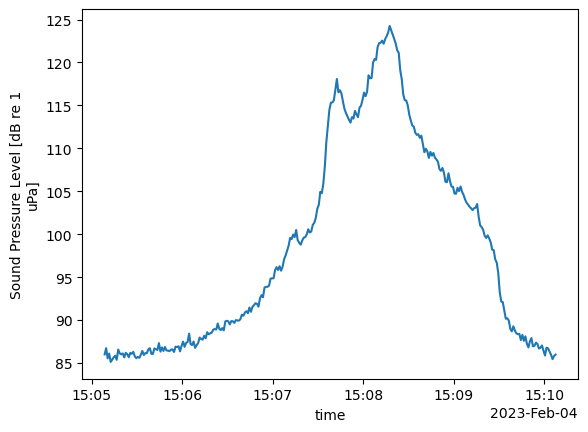

In [19]:
# Sound pressure level
fmin = 50
fmax = 48000

spl = acoustics.sound_pressure_level(spsd, fmin, fmax)
spl.plot()

### Decidecade Sound Pressure Levels

The last stat that IEC-40 requests are the decidecade SPLs, where the SPL is calculated for each decidecade frequency band. Note that the IEC-40 labels these as synonymous the third-octave SPLs; while for some applications this may be true, mathematically they have different definitions. 

To explain, a true octave is a frequency band where the upper frequency is double (i.e., base 2) that of the lower frequency. Third octaves are often measured because mammals to have evolved to interpret sound at this bandwidth. The true one-third octave is a frequency band where the upper frequency is 2^(1/3) = 1.25992 times the lower frequency. The decidecade band referenced by the IEC-40 refers to the one-tenth octave of base 10, where the upper frequency is 10 times that of the lower frequency. Mathematically this means the decidecade band has a bandwidth of 10^(1/10) = 1.25892. So, when reporting frequency analysis, it is important to note both the octave and its bandwidth.

We can calculate the SPL in each decidecade band using the function `decidecade_sound_pressure_level`. This function uses the same calculation as `sound_pressure_level` above and runs it on each tenth octave band. It returns 1 SPL in each frequency band every timestamp, so our boxplots show 5 minutes worth of SPL measurements in each decidecade band. You'll notice a similar spread as in the SPSDL boxplots, especially in the upper quantile. Boats are loud.

[[<matplotlib.axis.XTick at 0x1df862c4f50>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5')],
 (1.6532125137753437, 4.7160033436347994),
 (50.0, 120.0),
 Text(0.5, 0, 'log(Frequency) [Hz]'),
 Text(0, 0.5, 'Decidecade SPL [dB re 1 uPa]')]

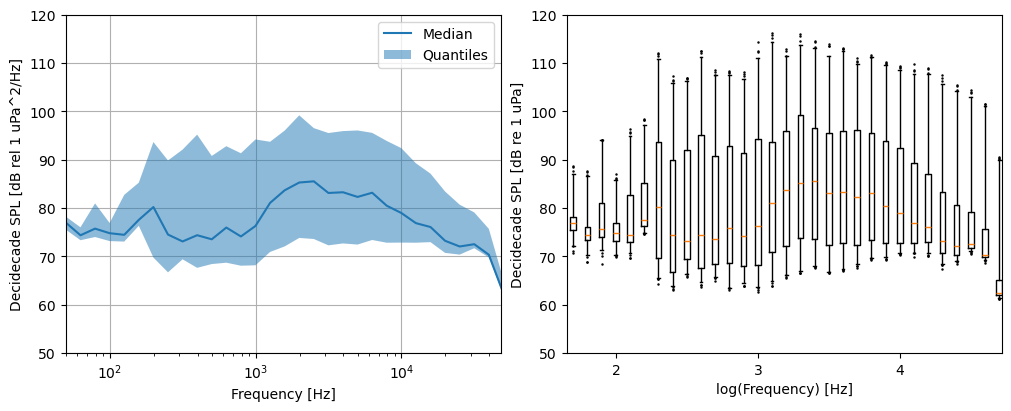

In [20]:
# Decidecade octave sound pressure level (also interquartile)
spl10 = acoustics.decidecade_sound_pressure_level(spsd, fmin, fmax)

# Plot the decidecade sound pressure level
fig, ax = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True)
fig, ax[0] = acoustics.graphics.plot_spectra(spl10.median("time"), fmin, fmax, fig=fig, ax=ax[0], label="Median")
ax[0].fill_between(
    spl10["freq_bins"],
    spl10.quantile(0.25, "time"),
    spl10.quantile(0.75, "time"),
    alpha=0.5,
    facecolor="C0",
    edgecolor=None,
    label="Quantiles"
)
ax[0].legend(loc="upper right")
ax[0].set_axisbelow(True)
ax[0].grid()
ax[0].set(ylim=(50, 120), ylabel="Decidecade SPL [dB rel 1 uPa^2/Hz]", xscale="log")

# Boxplots
ax[1].boxplot(
    spl10.values,
    whis=(1, 99),
    showfliers=True,
    positions=np.log10(spl10["freq_bins"].values),
    widths=0.04,
    flierprops={"marker": ".", "markersize": 1.5},
)
xticks = np.linspace(0, 5, 6)
ax[1].set(
    xticks=xticks,
    xticklabels=xticks.astype(int),
    xlim=(np.log10(45), np.log10(52000)),
    ylim=(50, 120),
    xlabel="log(Frequency) [Hz]",
    ylabel="Decidecade SPL [dB re 1 uPa]",
)

### Third Octave Sound Pressure Level

One can also calculate the true 1/3 octave SPLs using `third_octave_sound_pressure_level` if desired. Note the results are quite similar to `decidecade_sound_pressure_level`.

[[<matplotlib.axis.XTick at 0x1df868ff2d0>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5')],
 (1.6532125137753437, 4.7160033436347994),
 (50.0, 120.0),
 Text(0.5, 0, 'log(Frequency) [kHz]'),
 Text(0, 0.5, 'Third Octave SPL [dB re 1 uPa]')]

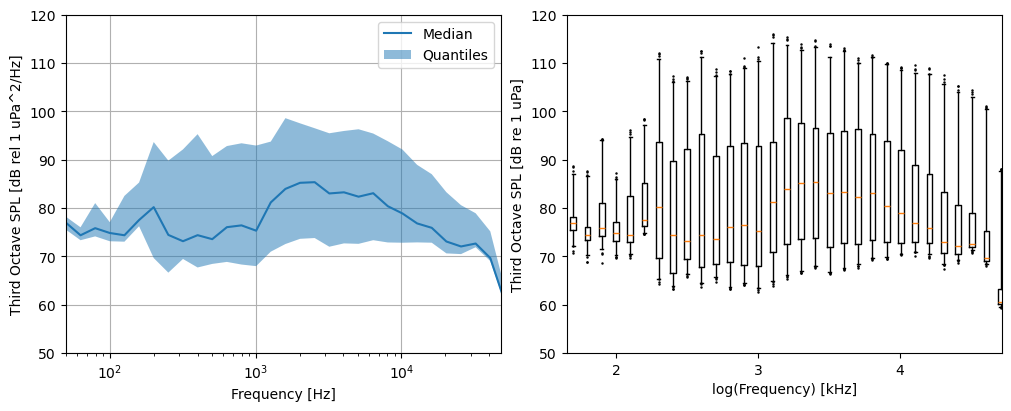

In [21]:
# Median third octave sound pressure level
spl3 = acoustics.third_octave_sound_pressure_level(spsd, fmin, fmax)

# Plot the decidecade sound pressure level
fig, ax = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True)
fig, ax[0] = acoustics.graphics.plot_spectra(spl3.median("time"), fmin, fmax, fig=fig, ax=ax[0], label="Median")
ax[0].fill_between(
    spl3["freq_bins"],
    spl3.quantile(0.25, "time"),
    spl3.quantile(0.75, "time"),
    alpha=0.5,
    facecolor="C0",
    edgecolor=None,
    label="Quantiles"
)
ax[0].legend(loc="upper right")
ax[0].set_axisbelow(True)
ax[0].grid()
ax[0].set(ylim=(50, 120), ylabel="Third Octave SPL [dB rel 1 uPa^2/Hz]", xscale="log")

# Boxplots
ax[1].boxplot(
    spl3.values,
    whis=(1, 99),
    showfliers=True,
    positions=np.log10(spl3["freq_bins"].values),
    widths=0.04,
    flierprops={"marker": ".", "markersize": 1.5},
)
xticks = np.linspace(0, 5, 6)
ax[1].set(
    xticks=xticks,
    xticklabels=xticks.astype(int),
    xlim=(np.log10(45), np.log10(52000)),
    ylim=(50, 120),
    xlabel="log(Frequency) [kHz]",
    ylabel="Third Octave SPL [dB re 1 uPa]",
)

### Sound Exposure Level and Marine Mammal Weightings

While the IEC-40 does not have recommendations for sound exposure level (SEL), it is a better parameter for quantifying auditory stress/injury to organisms. Sound exposure level is a metric that quantifies sound pressure level relative to exposure duration, based on the idea that that the effects on an organism's hearing are the same for equivalent totals sound energy received - even if that energy was received at different rates. Numerically, an SPL of 190 dB re 1 uPa over a 1 second interval and an SPL 160 dB re 1 uPa for 1000 seconds both have a SEL of 190 dB re 1 uPa^2 s.

The National Marine Fisheries Service (NMFS) publishes auditory weighting functions for five groups of marine mammals. These weighting functions are designed to try to emulate the auditory sensitivity of each group to better predict auditory injury thresholds. They are mathematically equivalent to band-pass filters. A link to the latest recommendations from NMFS is [here](https://www.fisheries.noaa.gov/national/marine-mammal-protection/marine-mammal-acoustic-technical-guidance-other-acoustic-tools).

The SEL function `sound_exposure_level` has a few inputs. One is the pressure spectral density (PSD) in Pa^2/Hz, found from `sound_pressure_spectral_density`. The 'n_bin' input to that function should be the same length of time as you want to calculate SEL for. If you would like to calculate the 24 hr SEL, you need 24 hours worth of data - the best way to do this and save computer RAM would be to calculate the PSD from each 1-5 minute individual file and then concatenate the PSD from each file together.
Set "group=None" to calculate the standard SEL. Set "group" to "LF" for 'low frequency' cetaceans; "HF" for 'high frequency' cetaceans; "VHF" for 'very high frequency' cetaceans; "PW" for phocid pinnepeds; and "OW" for otariid pinnepeds.


In [22]:
import xarray as xr

# Five minute SEL
spsd_300s = acoustics.sound_pressure_spectral_density(V, V.fs, bin_length=300)
# Calibrate PSD
fill_Sf = sensitivity_curve[-1].values
spsd_300s = acoustics.apply_calibration(spsd_300s, sensitivity_curve, fill_value=fill_Sf)

ds_sel = xr.Dataset()
ds_sel["sel"] = acoustics.sound_exposure_level(spsd_300s, None, fmin, fmax)
for group in ["LF", "HF", "VHF", "PW", "OW"]:
    ds_sel["sel_" + group.lower()] = acoustics.sound_exposure_level(
        spsd_300s, group, fmin, fmax
    )

print(ds_sel["sel"])
print("\n")
print(ds_sel.data_vars)

<xarray.DataArray 'sel' (time: 1)> Size: 4B
array([136.9158], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-02-04T15:07:37.996493339
Attributes:
    units:             dB re 1 uPa^2 s
    long_name:         Sound Exposure Level
    weighting_group:   None
    integration_time:  300 s
    freq_band_min:     50
    freq_band_max:     48000


Data variables:
    sel      (time) float32 4B 136.9
    sel_lf   (time) float32 4B 68.01
    sel_hf   (time) float32 4B 105.6
    sel_vhf  (time) float32 4B 112.0
    sel_pw   (time) float32 4B 94.66
    sel_ow   (time) float32 4B 85.09


Compare this to the 5 minute SPL:

In [23]:
spl_300s = acoustics.sound_pressure_level(spsd_300s, fmin, fmax)
print(spl_300s)

<xarray.DataArray (time: 1)> Size: 4B
array([112.14459], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-02-04T15:07:37.996493339
Attributes:
    units:          dB re 1 uPa
    long_name:      Sound Pressure Level
    freq_band_min:  50
    freq_band_max:  48000


We can look at the specific marine mammal auditory weighting and noise exposure functions as well using `nmfs_auditory_weighting`, given a frequency vector and one of the mammal groups. It outputs the weighting function and the exposure function (the inverse of the former) in units of dB. To convert back to a unitless magnitude, use `10 ** (<func> / 10)`. The exposure function shows the SEL in dB at and above which temporary or permanent hearing damage can occur to an individual in the specified group. The minimum value in the exposure function is the known or estimated injury level for a given group.

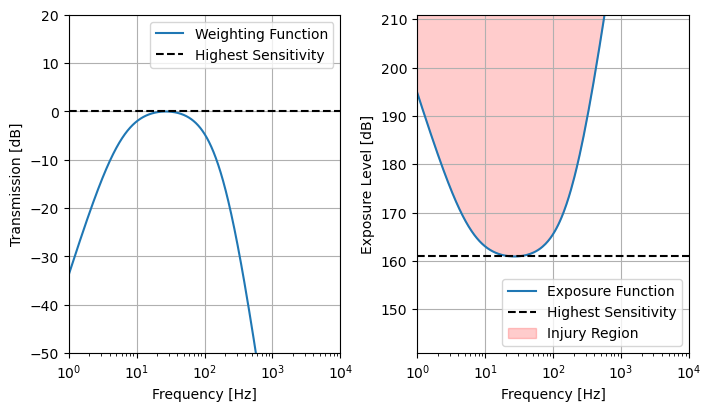

In [27]:
# Calculate weighting and exposure functions
weight_func, exp_func = acoustics.nmfs_auditory_weighting(spsd_300s["freq"], group="VHF")

fig, ax = plt.subplots(1,2, figsize=(7,4), subplot_kw={"xscale": "log"}, constrained_layout=True)
ax[0].plot(spsd_300s["freq"], weight_func, label="Weighting Function")
ax[0].axhline(y=0, color='k', linestyle='--', label="Highest Sensitivity")
ax[0].set(ylabel="Transmission [dB]", ylim=(-50, 20))
ax[0].legend(loc="upper right")

ax[1].plot(spsd_300s["freq"], exp_func, label="Exposure Function")
ax[1].axhline(y=exp_func.min(), color='k', linestyle='--', label="Highest Sensitivity")
ax[1].fill_between(spsd_300s["freq"], exp_func, np.ones_like(exp_func)*300, color='red', alpha=0.2, label="Injury Region")
ax[1].set(ylabel="Exposure Level [dB]", ylim=(exp_func.min()-20, exp_func.min()+50))
ax[1].legend(loc="lower right")

for a in ax:
    a.grid()
    a.set(xlabel="Frequency [Hz]", xlim=(1,1e4))